# Introduction

In so many NLP tasks, we have low number of labeled data for classification. Zero-shot classification via transformers can also be an alternative idea to solve the task in that case. However, the accuracy would be lower than accpted accuray.
In below, I will try to use Siamese Net on NLP classification task.
Siamese networks are similar neural networks where input vectors are passed through it to extract features , which are later passed through the triplet loss in the few shot learning process. Siamese Net orginially were used for image processing

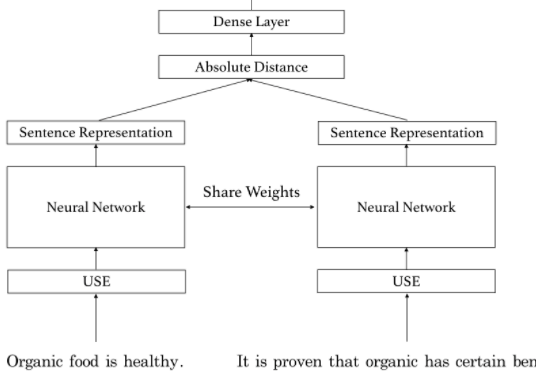

# Import

In [20]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [32]:
import pandas as pd
import numpy as np
import random
import warnings
import time
import datetime
import re
import string
import itertools
import pickle
import joblib
import nltk
import csv

from nltk.corpus import stopwords, wordnet
stop = set(stopwords.words('english'))
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from collections import Counter, defaultdict

import tensorflow as tf
import keras
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, Embedding, LSTM
from keras.models import Model
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score



from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizer_v2 import adam as adam_v2

from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [13]:
df = pd.read_csv('E:\Data/train.csv')
df.drop(['keyword', 'location', 'id'], axis=1, inplace=True)
display(df.sample(5))

,text,target
727,My ears are bleeding https://t.co/k5KnNwugwT,0
1667,Somehow find you and I collide http://t.co/Ee8...,0
828,New Expansion Ideas - Bard Class Holy Trinity ...,0
5668,@LisaVanderpump How many dogs do you have and ...,0
4386,Remove the http://t.co/7IEiZ619h0 and Linkury ...,0


In [14]:
df.shape

(7613, 2)

In [15]:
df['target'].value_counts()


0    4342
1    3271
Name: target, dtype: int64

# Data Cleaning

In [16]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

df['clean_text'] = df['text'].apply(lambda x: remove_url(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_emoji(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_html(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_punct(str(x)))
df['clean_text'] = df['clean_text'].apply(word_tokenize)
df['clean_text'] = df['clean_text'].apply(lambda x: [word.lower() for word in x])
df['clean_text'] = df['clean_text'].apply(lambda x: [word for word in x if word not in stop])
df['clean_text'] = df['clean_text'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
df['clean_text'] = df['clean_text'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
wnl = WordNetLemmatizer()
df['clean_text'] = df['clean_text'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
df['clean_text'] = df['clean_text'].apply(
    lambda x: [word for word in x if word not in stop])
df['clean_text'] = [' '.join(map(str, l)) for l in df['clean_text']]

In [17]:
display(df.sample(2))

,text,target,clean_text
962,New Ladies Shoulder Tote Handbag Women Cross B...,0,new lady shoulder tote handbag woman cross bod...
340,Lee does comedy: ÛÏ@LeeJasper: Working class ...,0,lee comedy ûïleejasper work class tory prepar...


## Contrastive Loss

In [18]:
disaster_initial = list(df[df['target'] == 1]['clean_text'])
non_disaster_initial = list(df[df['target'] == 0]['clean_text'])

# Selecting only 1000 samples for siamese model
disaster = disaster_initial[:1000]
non_disaster = non_disaster_initial[:1000]

# Creating pairs of data for siamese training => label 1 if pairs from same class otherwise 0
df2 = pd.DataFrame(columns=['text1', 'text2', 'label'])

for data in disaster:
  data1 = data
  data2 = random.choice(disaster)
  data3 = random.choice(non_disaster)

  df2.loc[len(df2)] = [data1, data2, 1]
  df2.loc[len(df2)] = [data1, data3, 0]


for data in non_disaster:
  data1 = data
  data2 = random.choice(non_disaster)
  data3 = random.choice(disaster)
  
  df2.loc[len(df2)] = [data1, data2, 1]
  df2.loc[len(df2)] = [data1, data3, 0]

In [19]:
df2.shape

(4000, 3)

In [20]:
display(df2.sample(5))

,text1,text2,label
1616,highqualitybird reverse situation lol dont kno...,themagickidraps upset rally upset burning buil...,1
182,pakistan air ambulance helicopter crash kill nine,thunderstorm little rain expect central califo...,1
578,people tattoo u allow donate blood receive blo...,i405 southbound coal creek pkwy collision bloc...,1
1908,suresh prabhu call harda derailment natural ca...,301dc cloudygoldrush hate white people mo,1
2071,progressive greeting month student would set p...,arsonist set nyc vegetarian restaurant fire po...,0


In [21]:
X_train, X_val, y_train, y_val = train_test_split(df2[['text1', 'text2']], df2['label'], test_size=0.2, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(3200, 2) (800, 2) (3200,) (800,)


In [22]:
X_train['text'] = X_train[['text1', 'text2']].apply(lambda x: str(x[0])+" "+str(x[1]), axis=1)

In [23]:
t = Tokenizer()
t.fit_on_texts(X_train['text'].values)

X_train['text1'] = X_train['text1'].astype(str)
X_train['text2'] = X_train['text2'].astype(str)
X_val['text1'] = X_val['text1'].astype(str)
X_val['text2'] = X_val['text2'].astype(str)

train_q1_seq = t.texts_to_sequences(X_train['text1'].values)
train_q2_seq = t.texts_to_sequences(X_train['text2'].values)
val_q1_seq = t.texts_to_sequences(X_val['text1'].values)
val_q2_seq = t.texts_to_sequences(X_val['text2'].values)

max_len = 200
train_q1_seq = pad_sequences(train_q1_seq, maxlen=max_len, padding='post')
train_q2_seq = pad_sequences(train_q2_seq, maxlen=max_len, padding='post')
val_q1_seq = pad_sequences(val_q1_seq, maxlen=max_len, padding='post')
val_q2_seq = pad_sequences(val_q2_seq, maxlen=max_len, padding='post')

In [24]:
embeddings_index = {}
f = open('E:/Data/glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [25]:
not_present_list = []
vocab_size = len(t.word_index) + 1
print('Loaded %s word vectors.' % len(embeddings_index))
embedding_matrix = np.zeros((vocab_size, len(embeddings_index['no'])))
for word, i in t.word_index.items():
    if word in embeddings_index.keys():
        embedding_vector = embeddings_index.get(word)
    else:
        not_present_list.append(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.zeros(300)

Loaded 400000 word vectors.


In [26]:
print(embedding_matrix.shape)

(6160, 300)


## Siamese Model

In [27]:
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss

In [28]:
def build_network():

  network = Sequential()
  network.add(Embedding(name="synopsis_embedd",input_dim =len(t.word_index)+1, 
                       output_dim=len(embeddings_index['no']),weights=[embedding_matrix], 
                       input_length=train_q1_seq.shape[1],trainable=False))
  network.add(LSTM(64,return_sequences=True, activation="relu"))
  network.add(Flatten())
  network.add(Dense(128, activation='relu',
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'))
  
  network.add(Dense(2, activation=None,
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'))
  
  #Force the encoding to live on the d-dimentional hypershpere
  network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))

  return network

In [33]:
input_1 = Input(shape=(train_q1_seq.shape[1],))
input_2 = Input(shape=(train_q2_seq.shape[1],))

network = build_network()

encoded_input_1 = network(input_1)
encoded_input_2 = network(input_2)

distance = Lambda(euclidean_distance)([encoded_input_1, encoded_input_2])

# Connect the inputs with the outputs
model = Model([input_1, input_2], distance)

model.compile(loss=contrastive_loss, optimizer=adam_v2.Adam(0.001))

In [34]:
y_train = np.asarray(y_train).astype('float32')
y_val = np.asarray(y_val).astype('float32')

In [35]:
model.fit([train_q1_seq,train_q2_seq],y_train.reshape(-1,1), epochs = 5, 
          batch_size=64,validation_data=([val_q1_seq, val_q2_seq],y_val.reshape(-1,1)))

Epoch 1/5
50/50 [==============================] - 42s 284ms/step - loss: 0.4864 - val_loss: 0.3554
Epoch 2/5
50/50 [==============================] - 12s 247ms/step - loss: 0.3170 - val_loss: 0.2876
Epoch 3/5
50/50 [==============================] - 12s 246ms/step - loss: 0.2393 - val_loss: 0.2588
Epoch 4/5
50/50 [==============================] - 12s 250ms/step - loss: 0.2743 - val_loss: 0.3392
Epoch 5/5
50/50 [==============================] - 12s 246ms/step - loss: 0.2624 - val_loss: 0.3254


## Saving model

In [36]:
model_json = model.to_json()
with open("siamesemodel-contrastive-loss.json", "w") as json_file:
    json_file.write(model_json)
#serialize weights to HDF5
model.save_weights("siamesemodel-contrastive-loss.h5")
print("Saved model to disk")

# load json and create model
# json_file = open('siamesemodel-contrastive-loss.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("siamesemodel-contrastive-loss.h5")
# print("Loaded model from disk")

Saved model to disk


In [37]:
non_disaster_initial[122]

'stormbeard steellord see juda priest 2005 rob come back scorpion support fuck annihilated place astonish gig'

In [38]:
prediction_data = "usdjpy despite richter scale overbought fxstreet line swissquote bullish long jason sen mr ambulance chaser b…"
prediction_vector = t.texts_to_sequences([prediction_data])
prediction_vector = pad_sequences(prediction_vector,maxlen=200)

assistant_data = disaster[11]
assistant_vector = t.texts_to_sequences([assistant_data])
assistant_vector = pad_sequences(assistant_vector,maxlen=200)

model.predict([prediction_vector, assistant_vector])

array([[0.10638112]], dtype=float32)

In [39]:
prediction_data = "usdjpy despite richter scale overbought fxstreet line swissquote bullish long jason sen mr ambulance chaser b…"
prediction_vector = t.texts_to_sequences([prediction_data])
prediction_vector = pad_sequences(prediction_vector,maxlen=200)

assistant_data = non_disaster[5]
assistant_vector = t.texts_to_sequences([assistant_data])
assistant_vector = pad_sequences(assistant_vector,maxlen=200)

model.predict([prediction_vector, assistant_vector])

array([[0.09569789]], dtype=float32)

## Disaster Tweets

In [40]:
disaster_initial[12]

'rain flood florida tampabay tampa 18 19 day ive lose count'

In [41]:
prediction_data = "cameroon bir soldier 05012020 invaded southerncameroons village kimar set ablaze total of"
prediction_vector = t.texts_to_sequences([prediction_data])
prediction_vector = pad_sequences(prediction_vector,maxlen=200)

assistant_data = disaster[11]
assistant_vector = t.texts_to_sequences([assistant_data])
assistant_vector = pad_sequences(assistant_vector,maxlen=200)

model.predict([prediction_vector, assistant_vector])

array([[0.08731698]], dtype=float32)

In [42]:
prediction_data = "cameroon bir soldier 05012020 invaded southerncameroons village kimar set ablaze total of"
prediction_vector = t.texts_to_sequences([prediction_data])
prediction_vector = pad_sequences(prediction_vector,maxlen=200)

assistant_data = non_disaster[11]
assistant_vector = t.texts_to_sequences([assistant_data])
assistant_vector = pad_sequences(assistant_vector,maxlen=200)

model.predict([prediction_vector, assistant_vector])

array([[0.03964339]], dtype=float32)

# Triplet Loss Function

#### Postive and anchor are in the same class and negative in the other class. We try to project the embeddings such that the distance of anchor to negative is alpha more than the distance from anchor to positive. Alpha is also know as the margin, if the difference of distance is greater than the margin than the loss is zero otherwise the difference in distance is considered as the triplet loss and the loss is back-propagated through the siamese network.

In [43]:
disaster_initial = list(df[df['target'] == 1]['clean_text'])
non_disaster_initial = list(df[df['target'] == 0]['clean_text'])

# Taking 1000 samples from the entire data
disaster = disaster_initial[:1000]
non_disaster = non_disaster_initial[:1000]

# Creating pairs of data for siamese training => labels for identity loss and class for disaster or non disaster
df2 = pd.DataFrame(columns=['Anchor', 'Positive', 'Negative', 'label', 'class'])

for data in disaster:
  a = data
  p = random.choice(disaster)
  n = random.choice(non_disaster)

  df2.loc[len(df2)] = [a, p, n, 1, 1]


for data in non_disaster:
  a = data
  p = random.choice(non_disaster)
  n = random.choice(disaster)
  
  df2.loc[len(df2)] = [a, p, n, 1, 0]

In [44]:
df2.shape

(2000, 5)

In [45]:
display(df2.sample(5))

,Anchor,Positive,Negative,label,class
799,500 death year foodborne illness frackfreelanc...,1943 poland work party prisoner nazi death cam...,tomcatarts annihilate legion survivor imperfec...,1,1
1204,lee comedy ûïleejasper work class tory prepar...,parksboardfacts first zippoline one want use c...,jorrynja 6 bfgfcrush terell,1,0
1541,new expansion idea bard class holy trinity 1,noches elbestia alexissanchez happy see teamma...,trillion cross line 3rd time fieldwide attack ...,1,0
348,moscowghost sayedridha aminakh congratulation ...,bluebirddenver fettilootch slanglucci oppressi...,ambulance sprinter automatic frontline vehicle...,1,1
533,irishspy dont think ally suck 1 million casualty,thedoolinggroup 2 injured 2 school bus collide...,casualty insurance job hunt willinghearted rpn,1,1


In [46]:
X, X_test, y, y_test = train_test_split(df2[['Anchor', 'Positive', 'Negative']], df2[['label', 'class']], test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X[['Anchor', 'Positive', 'Negative']], y[['label', 'class']], test_size=0.2, random_state=0)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(1280, 3) (320, 3) (400, 3) (1280, 2) (320, 2) (400, 2)


In [47]:
X_train['text'] = X_train[['Anchor', 'Positive', 'Negative']].apply(lambda x: str(x[0])+" "+str(x[1])+" "+str(x[2]), axis=1)

# Glove Embedding

In [48]:
t = Tokenizer()
t.fit_on_texts(X_train['text'].values)

X_train['Anchor'] = X_train['Anchor'].astype(str)
X_train['Positive'] = X_train['Positive'].astype(str)
X_train['Negative'] = X_train['Negative'].astype(str)
X_val['Anchor'] = X_val['Anchor'].astype(str)
X_val['Positive'] = X_val['Positive'].astype(str)
X_val['Negative'] = X_val['Negative'].astype(str)
X_test['Anchor'] = X_test['Anchor'].astype(str)
X_test['Positive'] = X_test['Positive'].astype(str)
X_test['Negative'] = X_test['Negative'].astype(str)

train_q1_seq = t.texts_to_sequences(X_train['Anchor'].values)
train_q2_seq = t.texts_to_sequences(X_train['Positive'].values)
train_q3_seq = t.texts_to_sequences(X_train['Negative'].values)
val_q1_seq = t.texts_to_sequences(X_val['Anchor'].values)
val_q2_seq = t.texts_to_sequences(X_val['Positive'].values)
val_q3_seq = t.texts_to_sequences(X_val['Negative'].values)
test_q1_seq = t.texts_to_sequences(X_test['Anchor'].values)
test_q2_seq = t.texts_to_sequences(X_test['Positive'].values)
test_q3_seq = t.texts_to_sequences(X_test['Negative'].values)

max_len = 200
train_q1_seq = pad_sequences(train_q1_seq, maxlen=max_len, padding='post')
train_q2_seq = pad_sequences(train_q2_seq, maxlen=max_len, padding='post')
train_q3_seq = pad_sequences(train_q3_seq, maxlen=max_len, padding='post')
val_q1_seq = pad_sequences(val_q1_seq, maxlen=max_len, padding='post')
val_q2_seq = pad_sequences(val_q2_seq, maxlen=max_len, padding='post')
val_q3_seq = pad_sequences(val_q3_seq, maxlen=max_len, padding='post')
test_q1_seq = pad_sequences(test_q1_seq, maxlen=max_len, padding='post')
test_q2_seq = pad_sequences(test_q2_seq, maxlen=max_len, padding='post')
test_q3_seq = pad_sequences(test_q3_seq, maxlen=max_len, padding='post')

In [50]:
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
embeddings_index = {}
f = open('E:/Data/glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [51]:
not_present_list = []
vocab_size = len(t.word_index) + 1
print('Loaded %s word vectors.' % len(embeddings_index))
embedding_matrix = np.zeros((vocab_size, len(embeddings_index['no'])))
for word, i in t.word_index.items():
    if word in embeddings_index.keys():
        embedding_vector = embeddings_index.get(word)
    else:
        not_present_list.append(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.zeros(300)

Loaded 400000 word vectors.


In [52]:
print(embedding_matrix.shape)

(5759, 300)


## Siamese

In [53]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

In [59]:
def embedding_model():

  network = Sequential()
  network.add(Embedding(name="synopsis_embedd",input_dim =len(t.word_index)+1, 
                       output_dim=len(embeddings_index['no']),weights=[embedding_matrix], 
                       input_length=train_q1_seq.shape[1],trainable=False))
  network.add(LSTM(64,return_sequences=True, activation="relu"))
  network.add(Flatten())
  network.add(Dense(128, activation='relu',
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'))
  
  network.add(Dense(2, activation=None,
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'))
  
  #Force the encoding to live on the d-dimentional hypershpere
  # network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))

  return network


def build_network(base_model):

  input_1 = Input(shape=(train_q1_seq.shape[1],))
  input_2 = Input(shape=(train_q2_seq.shape[1],))
  input_3 = Input(shape=(train_q3_seq.shape[1],))

  A = base_model(input_1)
  P = base_model(input_2)
  N = base_model(input_3)

  loss = Lambda(triplet_loss)([A, P, N])
  model = Model(inputs = [input_1, input_2, input_3], outputs = loss)
  model.compile(loss = identity_loss, optimizer = adam_v2.Adam(0.001))
  return model

In [60]:
base_model = embedding_model()
model = build_network(base_model)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 2)            3459926     input_11[0][0]                   
                                                                 input_12[0][0]             

In [61]:
y_train_label = np.asarray(y_train['label']).astype('float32')
y_val_label = np.asarray(y_val['label']).astype('float32')
y_test_label = np.asarray(y_test['label']).astype('float32')

y_train_class = np.asarray(y_train['class']).astype('float32')
y_val_class = np.asarray(y_val['class']).astype('float32')
y_test_class = np.asarray(y_test['class']).astype('float32')

In [62]:
history = model.fit([train_q1_seq,train_q2_seq, train_q3_seq],y_train_label.reshape(-1,1), epochs = 5, 
          batch_size=64,validation_data=([val_q1_seq, val_q2_seq, val_q3_seq],y_val_label.reshape(-1,1)))

Epoch 1/5
20/20 [==============================] - 14s 460ms/step - loss: 0.3498 - val_loss: 0.1876
Epoch 2/5
20/20 [==============================] - 8s 386ms/step - loss: 0.1551 - val_loss: 0.1555
Epoch 3/5
20/20 [==============================] - 7s 373ms/step - loss: 0.1034 - val_loss: 0.1528
Epoch 4/5
20/20 [==============================] - 7s 370ms/step - loss: 0.0669 - val_loss: 0.1363
Epoch 5/5
20/20 [==============================] - 7s 372ms/step - loss: 0.0473 - val_loss: 0.1671


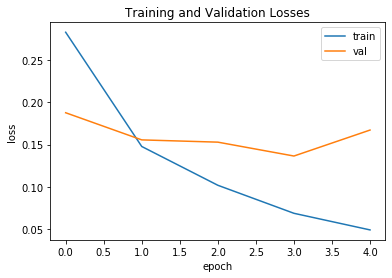

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 12)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [64]:
# Save model for further use
# serialize model to JSON
model_json = model.to_json()
with open("siamesemodel-triplet-loss.json", "w") as json_file:
    json_file.write(model_json)
#serialize weights to HDF5
model.save_weights("siamesemodel-triplet-loss.h5")
print("Saved model to disk")

# load json and create model
# json_file = open('siamesemodel-triplet-loss.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("siamesemodel-triplet-loss.h5")
# print("Loaded model from disk")

Saved model to disk


# Evaluation

In [65]:
X_train_eval = base_model.predict(train_q1_seq)
X_test_eval = base_model.predict(test_q1_seq)

# TSNE - dimensionality reduction for data visualization
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_eval)

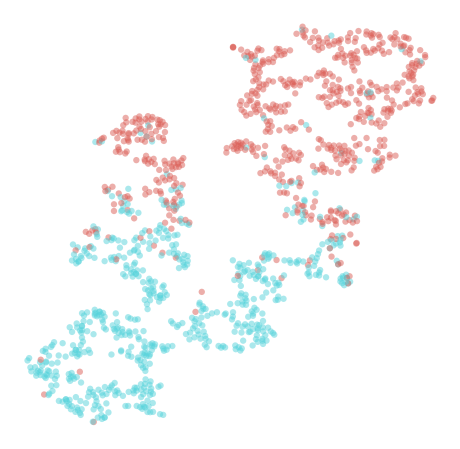

In [66]:
def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

scatter(train_tsne_embeds, y_train_class)

In [67]:
# classifier that computes the class of a specific embedding for prediction purposes
classifier_input = Input(shape=(2,))
classifier_output = Dense(2, activation='softmax')(classifier_input)
classifier_model = Model(classifier_input, classifier_output)

# onehot encoding vectors to 2 classes
Y_train_onehot = np_utils.to_categorical(y_train_class, 2)
Y_test_onehot = np_utils.to_categorical(y_test_class, 2)

classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
classifier_model.fit(X_train_eval,Y_train_onehot, validation_data=(X_test_eval, Y_test_onehot),epochs=5)

Epoch 1/5
40/40 [==============================] - 1s 6ms/step - loss: 0.5630 - accuracy: 0.8706 - val_loss: 0.5813 - val_accuracy: 0.8025
Epoch 2/5
40/40 [==============================] - 0s 2ms/step - loss: 0.5517 - accuracy: 0.8671 - val_loss: 0.5724 - val_accuracy: 0.8050
Epoch 3/5
40/40 [==============================] - 0s 2ms/step - loss: 0.5380 - accuracy: 0.8785 - val_loss: 0.5641 - val_accuracy: 0.8150
Epoch 4/5
40/40 [==============================] - 0s 1ms/step - loss: 0.5276 - accuracy: 0.8914 - val_loss: 0.5563 - val_accuracy: 0.8225
Epoch 5/5
40/40 [==============================] - 0s 1ms/step - loss: 0.5017 - accuracy: 0.9113 - val_loss: 0.5490 - val_accuracy: 0.8300


In [68]:
input = X_test_eval[:10]
prediction = classifier_model.predict(input)
print(prediction)

[[0.39107004 0.60892993]
 [0.5468884  0.4531115 ]
 [0.6520119  0.34798813]
 [0.34785187 0.6521482 ]
 [0.52536094 0.47463915]
 [0.593142   0.406858  ]
 [0.63432115 0.36567888]
 [0.5095814  0.49041855]
 [0.59302354 0.40697646]
 [0.46632037 0.5336797 ]]
